In [1]:
# Package Imports
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

from shapely.geometry import LineString, Polygon, Point
from shapely.affinity import rotate, scale

import pulp

from spopt.locate import PMedian

from importlib import reload

# to load the interactive plotting version
#%matplotlib widget
# or regular
# %matplotlib inline
# %gui qt
import vispy
%matplotlib qt

# Importing my modules
from src import data_loading, plotting, geometry_operations, optimization_functions, geometry_utilities, classes, cable_road_computation, mechanical_computations

In [2]:
reload(data_loading)
tree_gdf, height_gdf = data_loading.load_processed_gdfs()

#### Joining and Overlaying Anchor Areas and Road on the Map

##### Recording coordinates with interactive figure

In [3]:
# coords = []
# fig, ax = plt.subplots()
# ax.set_xlabel('X coordinate', fontsize=15)
# ax.set_ylabel('Y coordinate', fontsize=15)
# ax.scatter(tree_gdf["x"],tree_gdf["y"])

# cid = fig.canvas.mpl_connect('button_press_event',  lambda event: plotting.onclick(event,coords))

In [4]:
# disconnect the interactive figure so it doesnt eat up resources
# fig.canvas.mpl_disconnect(cid)

##### Creating extra-geometry from manual coordinates

In [5]:
# manually insert those coordinates
# recorded coordinates for the given areas
downhill_anchors = Polygon([Point(xy) for xy in [(-123.88268627035482, 83.05479790035122), (-74.89307684787903, 138.5299549848453), (-21.10056454084676, 161.97821725767267), (-6.051468835903222, 148.2524051955298), (-60.16417466857257, 116.79741921978575), (-115.23746107815322, 64.75371515082742)]])
uphill_anchors = Polygon([Point(xy) for xy in [(-55.04107825837903, -15.31352187833928), (-17.578435758838708, -17.601157222029755), (4.194723984483858, -1.5877098161964227), (30.450593086725803, -30.18315161232738), (-11.49475877173387, -41.04941949485714), (-58.5632070403871, -38.189875315244045)]])
# road = LineString([(-57.282432937838706, -17.029248386107135), (-34.86888614324194, -21.604519073488092), (-15.337081079379033, -15.31352187833928), (-0.2879853744354932, -7.878707011345227), (12.51975565104837, 6.990922722642864), (19.884206740701615, 21.86055245663097)])
# road = LineString([(-59.52378761729838, -12.453977698726185), (-41.91314370725806, -13.597795370571419), (-18.218822810112897, -10.16634235503571), (3.2341434075725886, 0.12801669157144602), (15.401497381782264, 23.576278964398824), (17.00246500996775, 26.43582314401192)])
road = LineString([(-89.6286010742188, -24.4624996185303),(-69.618896484375, -20.364200592041),(-41.314998626709, -13.9251003265381),(-29.2644004821777, -8.47910022735596),(-20.2950000762939, -3.67030000686646),(-15.375, -0.148599997162819),(-6.49030017852783, 2.74860000610352),(0.943400025367737, 3.86450004577637),(15.1605997085571, -0.302300006151199),(29.3377990722656, -3.47709989547729)])

inner_forest = Polygon([Point(xy) for xy in [(-105.43005197808363, 62.73802056488026), (-10.557896233758669, 146.34023494632802), (13.160142702322588, 51.07259530235265), (8.890895693827957, 9.27148811162877), (-55.62217021231302, -10.17088732591722), (-81.71201304200238, 18.992675830401765)]])

extra_geometry_gpd = gpd.GeoDataFrame(pd.DataFrame({"name":["uphill_anchors","road","downhill_anchors","inner_forest"],"geometry":[uphill_anchors,road,downhill_anchors,inner_forest]}))

# set the name as index to easily select the geometry
extra_geometry_gpd.set_index("name", inplace = True)
extra_geometry_gpd.loc['road']

# plotting.plot_gdfs([tree_gdf,extra_geometry_gpd])

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


geometry    LINESTRING (-89.62860 -24.46250, -69.61890 -20...
Name: road, dtype: geometry

#### Generating Eligible Trees and Road Pathway

Getting the points along the road

In [6]:
interval = 2
road_points = geometry_operations.generate_road_points(extra_geometry_gpd.loc['road'].geometry, interval)
# plotting.plot_scatter_xy(road_points)

Getting the trees contained in the anchor/target tree polygons

In [7]:
# get the eligible anchor and target trees inside the polygon
anchor_trees_gdf = geometry_operations.filter_gdf_by_contained_elements(tree_gdf, extra_geometry_gpd.loc["uphill_anchors"].geometry)
target_trees_gdf = geometry_operations.filter_gdf_by_contained_elements(tree_gdf,extra_geometry_gpd.loc["downhill_anchors"].geometry)
inner_forest_gdf = geometry_operations.filter_gdf_by_contained_elements(tree_gdf, extra_geometry_gpd.loc["inner_forest"].geometry)
harvesteable_trees_gdf = pd.concat([target_trees_gdf,inner_forest_gdf])

# and check if the anchor trees look good
#plotting.plot_scatter_xy(harvesteable_trees_gdf.geometry)

#### Generating Possible Lines

##### Setting and rotating the slope line

In [8]:
slope_degree = 29

# set a orientation line we can plan the line deviation around
slope_line = LineString([(0,0),(0,1)])
slope_line = rotate(slope_line, slope_degree)

# scale the line by a factor of 100 and plot it
slope_line = scale(slope_line,100,100)

# ax = plotting.plot_equal_axis(slope_line)
# ax.scatter(bestand_3_csv["x"], bestand_3_csv["y"])

##### Constraining lines to those with suitable anchor trees

In [9]:
import math
# Filter out uphill anchor trees with min_anchor_diameter < 
max_supported_force = 80 #in kN
security_factor = 3 #for normal conditions

# original:  kn = BHD²(in dm) \*10 / Reduktionsfaktor -> *1000 for Newton
min_talanker_diameter = (math.sqrt((max_supported_force*security_factor)/10))*10
print("Min BHD in cm is ",min_talanker_diameter)
target_trees_gdf["max_supported_force"] = (((target_trees_gdf["BHD"]**2)*10*1000)/security_factor)

# And filter the target trees - target trees = Talanker
#target_trees_gdf_filtered_diameter = target_trees_gdf[target_trees_gdf["BHD"]>min_talanker_diameter]
# skipping the filtering since we do this later
target_trees_gdf_filtered_diameter = target_trees_gdf
# target_trees_gdf_filtered_diameter.plot()

# anchor trees also have the max supported pulling force
anchor_trees_gdf["max_supported_force"] = (((anchor_trees_gdf["BHD"]**2)*10*1000)/security_factor)
anchor_trees_gdf_filtered_diameter = anchor_trees_gdf

Min BHD in cm is  48.98979485566356


/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


##### Generating the possible lines depending on the slope

In [10]:
# %load_ext line_profiler

In [16]:
reload(geometry_operations)
reload(geometry_utilities)
reload(plotting)
reload(classes)
reload(cable_road_computation)
reload(mechanical_computations)
plot_possible_lines = False

# expression for debugging
# %lprun -T tmp0.txt -f cable_road_computation.compute_initial_cable_road line_gdf, start_point_dict = cable_road_computation.generate_possible_lines(road_points, target_trees_gdf_filtered_diameter, anchor_trees_gdf_filtered_diameter, tree_gdf, slope_line, height_gdf, plot_possible_lines)
line_gdf, start_point_dict = cable_road_computation.generate_possible_lines(road_points, target_trees_gdf_filtered_diameter, anchor_trees_gdf_filtered_diameter, tree_gdf, slope_line, height_gdf, plot_possible_lines)
print("we have n lines: ",len(line_gdf))

# unpack to geopandas
buffer = gpd.GeoSeries(line_gdf["line_candidates"].values)
new_line_gdf = gpd.GeoDataFrame(geometry=buffer)
new_line_gdf[line_gdf.columns] = line_gdf[line_gdf.columns].values
new_line_gdf["line_length"] = new_line_gdf.geometry.length
line_gdf = new_line_gdf

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


10112  candidates initially
9681  after slope deviations
99  after supports trees
7  after possible anchor triples
Computing initial cable road


In [104]:
line_gdf.iloc[0].possible_anchor_triples[0]

(<shapely.geometry.linestring.LineString at 0x7f2ca1cbb760>,
 <shapely.geometry.linestring.LineString at 0x7f2ca1cbaa10>)

In [109]:
reload(plotting)
plotting.plot_gdf_with_anchors_and_supports([target_trees_gdf_filtered_diameter,anchor_trees_gdf_filtered_diameter, inner_forest_gdf, extra_geometry_gpd], line_gdf)

In [107]:
%store line_gdf
# line_gdf.columns

Stored 'line_gdf' (GeoDataFrame)


#### Optimization Setup

In [27]:
# reload(geometry_operations)
reload(optimization_functions)

# Apply the Line Cost Function:
uphill_yarding = 1
large_yarder = 0
intermediate_support_height = 12 #take the average for now
line_gdf["line_cost"] = [optimization_functions.line_cost_function(line_gdf["line_length"][index], uphill_yarding, large_yarder,intermediate_support_height,line_gdf["number_of_supports"][index]) for index in range(len(line_gdf))]

# Create a matrix with the distance between every tree and line and the distance between the support (beginning of the CR) and the carriage (cloests point on the CR to the tree)
distance_tree_line, distance_carriage_support = geometry_operations.compute_distances_facilities_clients(harvesteable_trees_gdf, line_gdf)

# sort the facility (=lines) and demand points (=trees)
facility_points_gdf = line_gdf.reset_index()
demand_points_gdf = harvesteable_trees_gdf.reset_index()

# set up the solver
solver = pulp.PULP_CBC_CMD(msg=False, warmStart=True)
name = "model"

# create the nr of possible facilities and clients 
client_range = range(distance_tree_line.shape[0])
facility_range = range(distance_tree_line.shape[1])

# add facility cost with an optional scaling factor
facility_scaling_factor = 0.1

facility_cost = line_gdf.line_cost.values*facility_scaling_factor

# create the aij cost matrix, which is really just the distance from the tree to the line
aij = distance_tree_line

# collect the matrices needed for the optimization
tree_volumes_list = harvesteable_trees_gdf["crownVolume"]
angle_between_supports_list = line_gdf["angle_between_supports"]
# cost_distance_tree_line
# distance_carriage_support

average_steepness = geometry_operations.compute_average_terrain_steepness(line_gdf, height_gdf)

# and the productivity cost combination of each line combination
productivity_cost = optimization_functions.calculate_productivity_cost(client_range, facility_range, aij, distance_carriage_support, average_steepness)

#### SpOPT

Creating our custom problem with constraints

- Obj Func v4:
	- ```sum(harvest_time * cli_assgn_vars[cli][fac])```
		- minimize the overall harvest time between clients and the factory they are assigned too
		- ```harvest_time = yarding_distance+lateral_yarding_distance+tree_volume+harvest_intensity+slope```
	- ```sum(fac_vars[fac]*fac_cost[fac] for fac in facility_range])```
		- minimize the sum of factory costs

- Matrices:
	- Lineactiveindex = fac_vars = $[l1+l2...]$
	- linetreeactiveindex = cli_assgn_vars = $[[l1*cli1+l1*cli2...],[l2*cli1+l2*cli2+....]]$

	- fac_cost: the cost of each line
	- cli_demand: mocked variable as of now, can be changed to reflect profit of given tree

- Constraints:
	- Constraint 1:
		- Each client is only assigned to one factory: ```pulp.lpSum([cli_assgn_vars[cli][fac] for fac in facility_range]) == 1```

	- Constraint 2: 
		- Every factory that has a client assigned must be opened: ```lscp.problem += fac_vars[fac] - cli_assgn_vars[cli][fac] >= 0```



In [28]:
# c = [model_list[0].cli_assgn_vars[cli][fac].value() for cli in client_range for fac in facility_range]
# plt.scatter(c, np.arange(len(c)))
reload(optimization_functions)

def optimize_cable_roads(name, aij, facility_range, client_range, facility_cost, start_point_dict, productivity_cost, step, steps):
    # init the model with name and the problem - this only gives it a name and tells it to minimize the obj function
    problem = pulp.LpProblem(name, pulp.LpMinimize)
    model = PMedian(name, problem, aij)

    # Add the facilities as fac_vars and facility_clients as cli_assgn_vars
    optimization_functions.add_facility_variables(model, facility_range)
    optimization_functions.add_facility_client_variables(model, facility_range, client_range)

    # Add the objective functions
    optimization_functions.add_moo_objective_function(model, facility_range, client_range, facility_cost, start_point_dict, productivity_cost, step, steps)

    # Assignment/demand constraint - each client should 
    # only be assigned to one factory
    optimization_functions.add_singular_assignment_constraint(model, facility_range, client_range)

    # Add opening/shipping constraint - each factory that has a client assigned to it should also be opened
    optimization_functions.add_facility_is_opened_constraint(model, facility_range, client_range)

    model = model.solve(solver)
    return model

In [29]:
model_list = []
steps = 3

# iterate combinations of 0.1 steps for a MOO tradeoff
for i in range(steps):
    model = optimize_cable_roads(name, aij, facility_range, client_range, facility_cost, start_point_dict, productivity_cost, i, steps)
    model_list.append(model)


In [30]:
reload(plotting)
for i in range(steps):
    plotting.plot_p_median_results(model_list[i], facility_points_gdf, demand_points_gdf, anchor_trees_gdf_filtered_diameter, target_trees_gdf_filtered_diameter, line_gdf)

In [23]:
# visualize optimization outcome, using matplotlib.pyplot
plt.figure(figsize=(15,8))

obj_1_list = [i for i in range(steps)]

# Value of objective function
obj_2_list = [model_list[i].problem.objective.value() for i in range(steps)]

obj_difference = [obj_2_list[i+1]-obj_2_list[i] for i in range(steps-1)]
obj_difference.append(0)

plt.plot(obj_1_list,obj_2_list, color="red")

plt.xlabel("Objective Tradeoff",size=20)
plt.ylabel("Objective Function Value",size=20)
# -- add plot title
plt.title("Combined Objective Function Value",size=32)
# -- show plot
plt.show()

#### PyMOO Testing

In [54]:
import moo_optimization_functions

In [56]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize

#import moo_optimization_functions
reload(moo_optimization_functions)

cost_matrix = aij
problem = moo_optimization_functions.SupportLinesProblem(cost_matrix, facility_cost)
termination = get_termination("n_gen", 7)

reload(optimization_functions)

client_range = cost_matrix.shape[0]
facility_range = cost_matrix.shape[1]

algorithm = NSGA2(
    population=100,
    sampling=IntegerRandomSampling(),
    mutation=moo_optimization_functions.MyMutation(),
    repair=moo_optimization_functions.MyRepair(),
)

res = minimize(problem,
               algorithm,
               termination,
               verbose=True,
               return_least_infeasible=True,
               seed=2)

X = res.X
F = res.F

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      8 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      200 |     14 |  0.000000E+00 |  0.000000E+00 |  0.3124098432 |         ideal
     3 |      300 |     16 |  0.000000E+00 |  0.000000E+00 |  0.2928140407 |         ideal
     4 |      400 |     28 |  0.000000E+00 |  0.000000E+00 |  0.1129085448 |         ideal
     5 |      500 |     39 |  0.000000E+00 |  0.000000E+00 |  0.0542389790 |         ideal
     6 |      600 |     40 |  0.000000E+00 |  0.000000E+00 |  0.1437597508 |         nadir
     7 |      700 |     49 |  0.000000E+00 |  0.000000E+00 |  0.0062614292 |             f


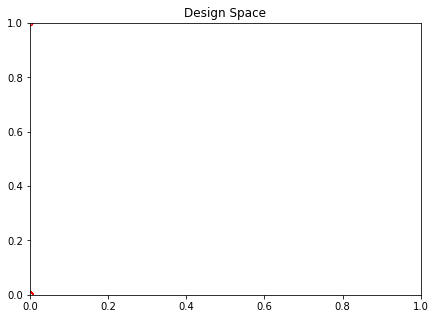

In [57]:
import matplotlib.pyplot as plt
xl, xu = problem.bounds()
plt.figure(figsize=(7, 5))
plt.scatter(X[:, 0], X[:, 1], s=30, facecolors='none', edgecolors='r')
plt.xlim(xl[0], xu[0])
plt.ylim(xl[1], xu[1])
plt.title("Design Space")
plt.show()

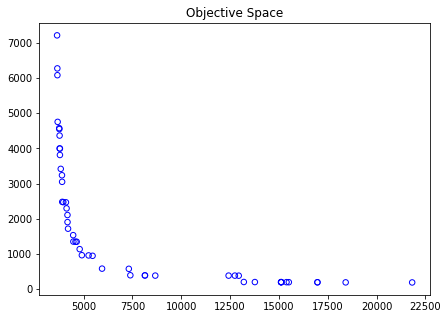

In [58]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()

In [60]:
x_sol = X[-10]

# Debugging
variable_matrix = x_sol.reshape((len(demand_points_gdf)+1,len(line_gdf)))

cli_assgn_vars = variable_matrix[:-1]
fac_vars = variable_matrix[-1]

#fac_vars
print(cli_assgn_vars[1:5])
#print(np.sum(cli_assgn_vars, axis=1))
print(fac_vars)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0]


In [1]:
import chart_studio.plotly as py

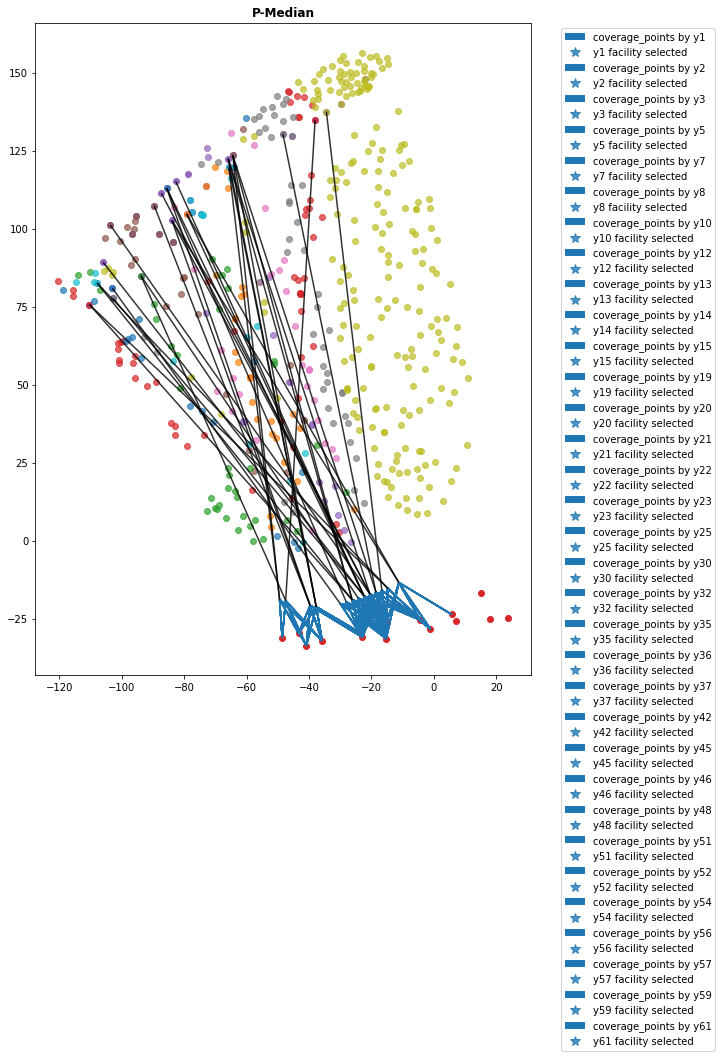

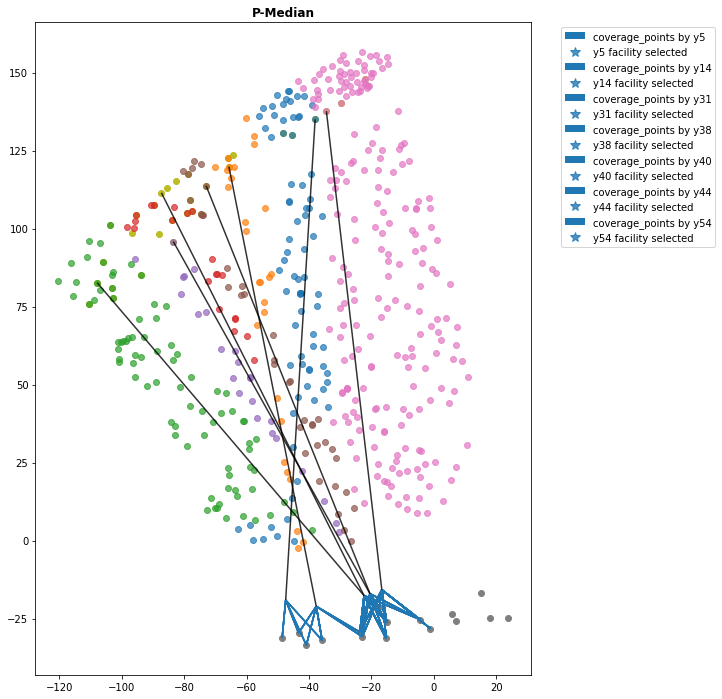

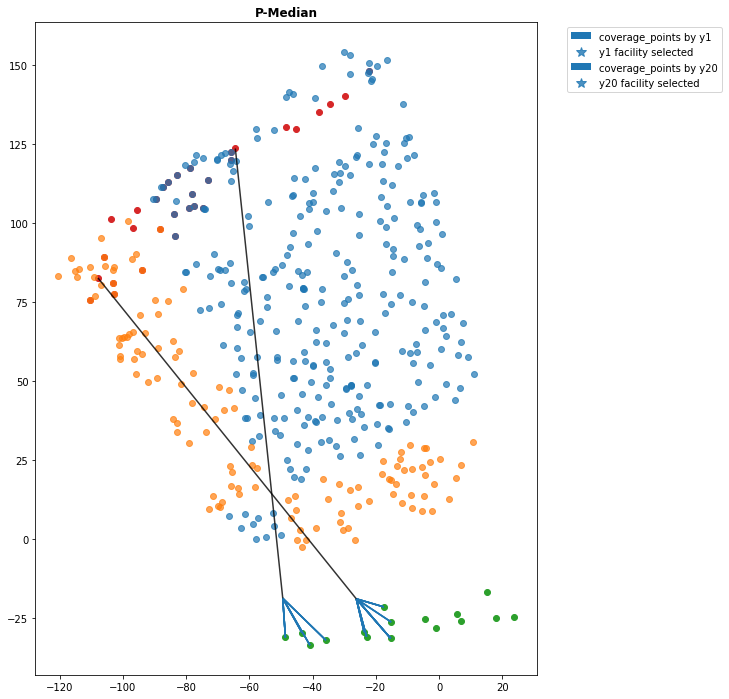

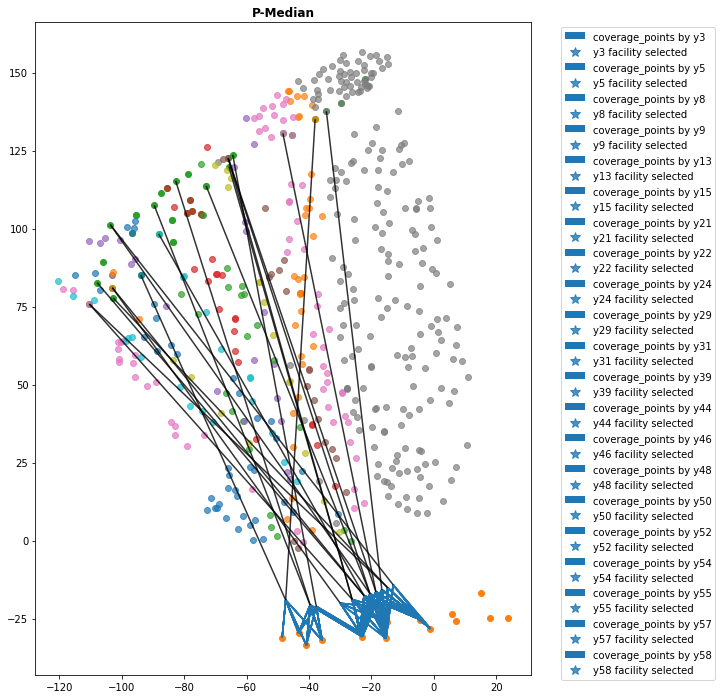

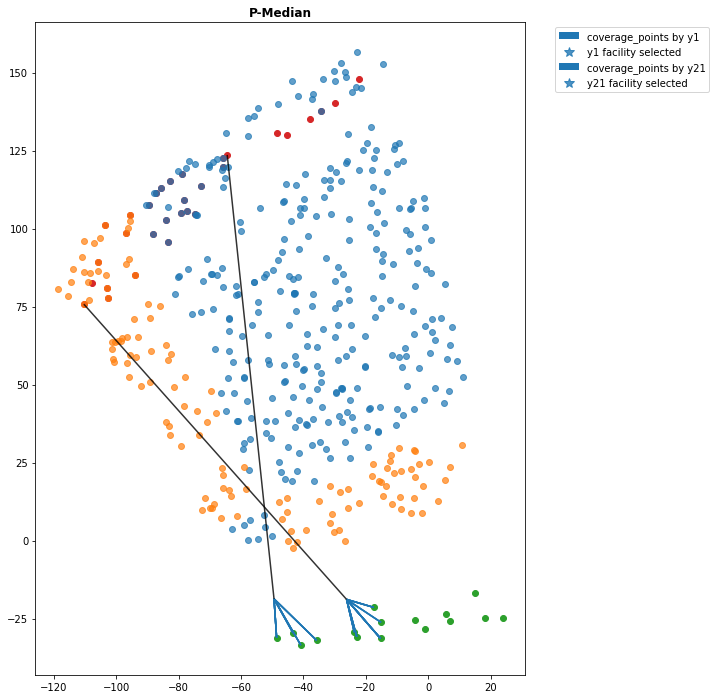

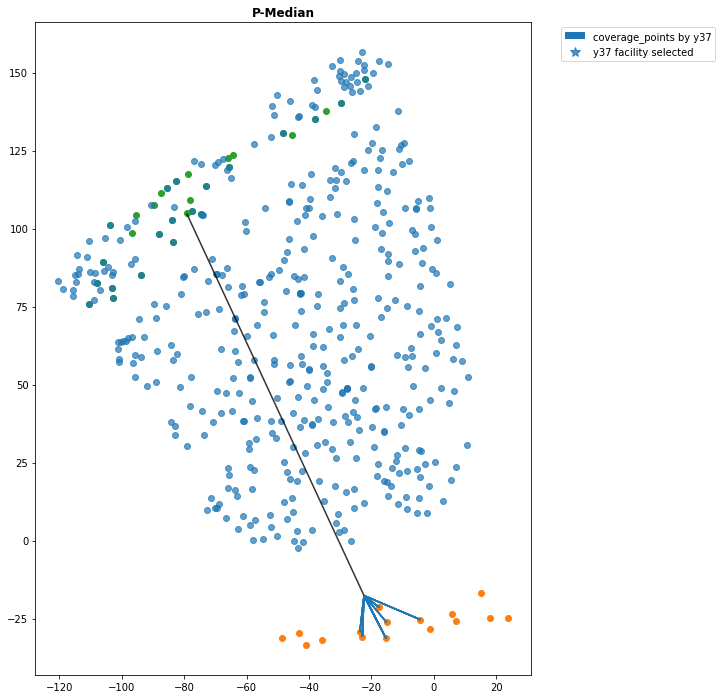

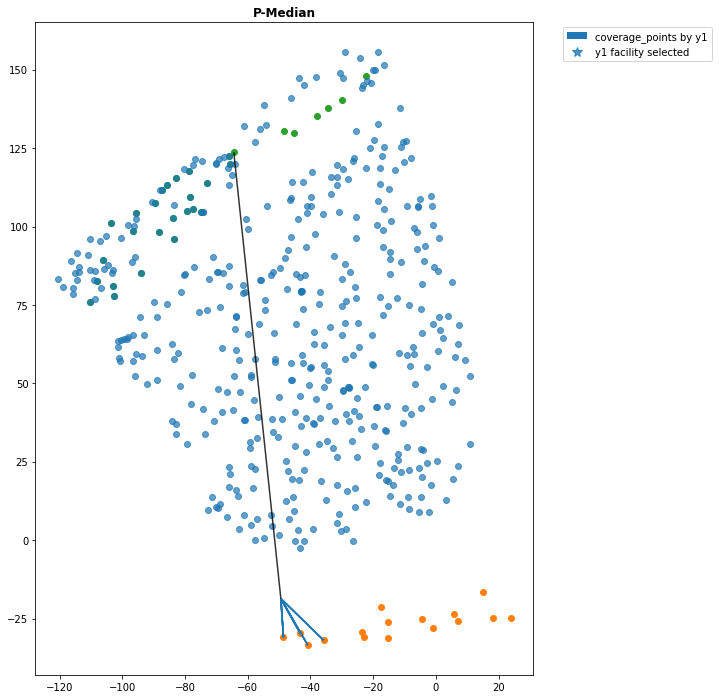

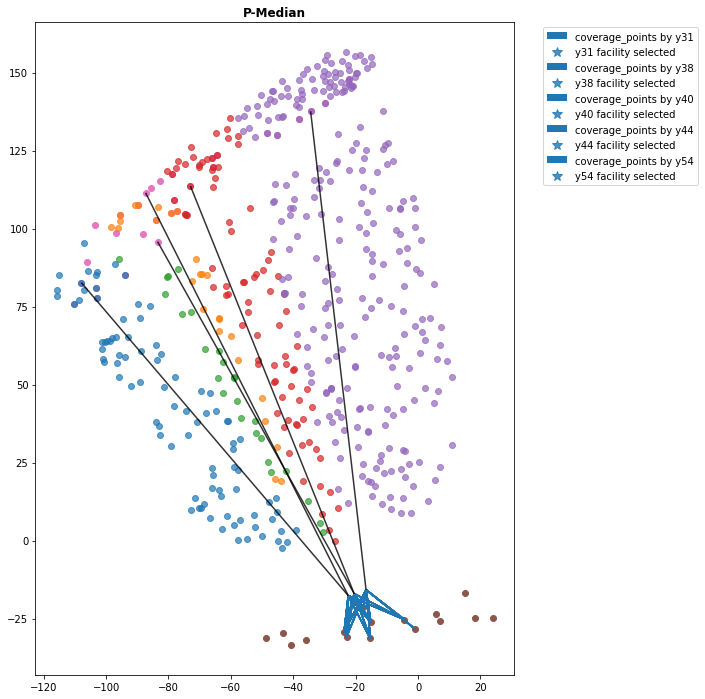

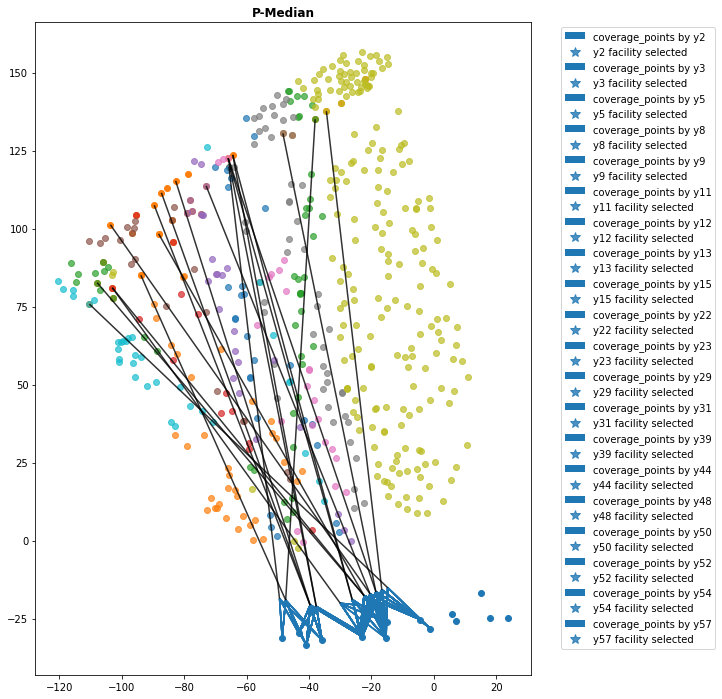

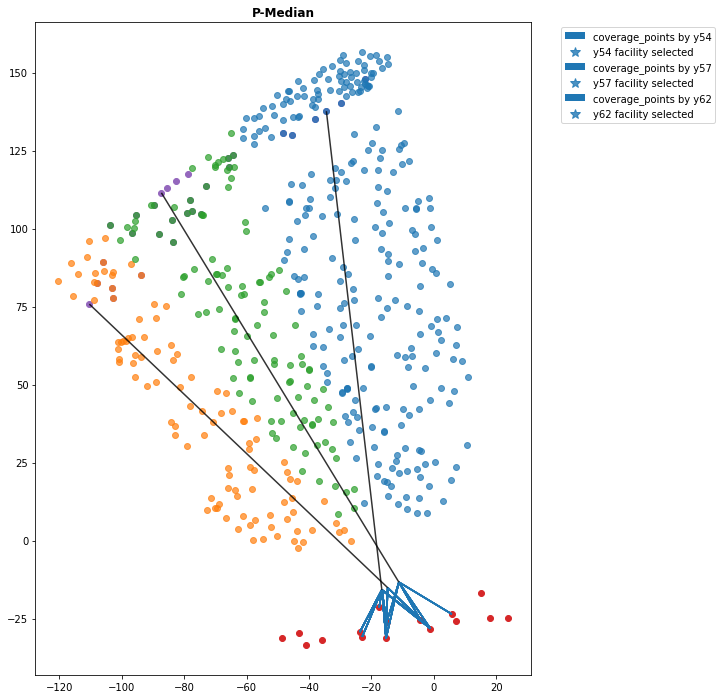

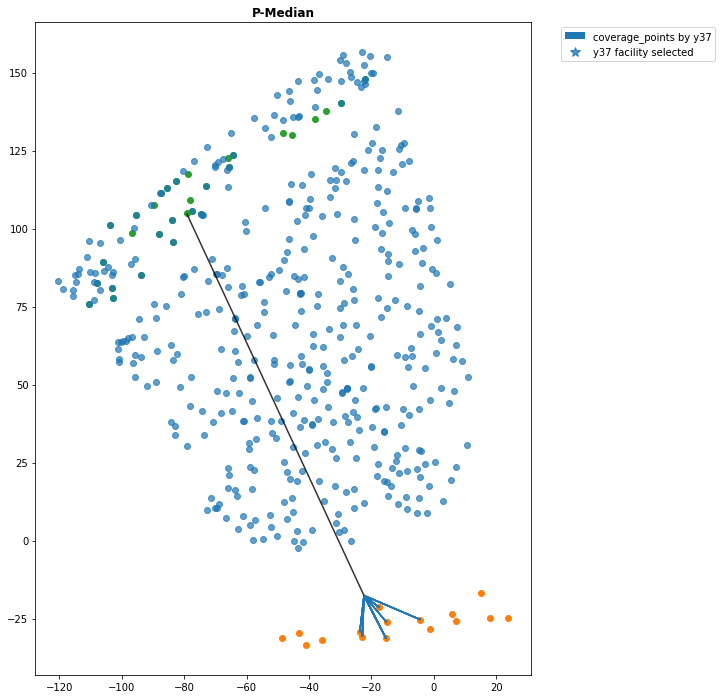

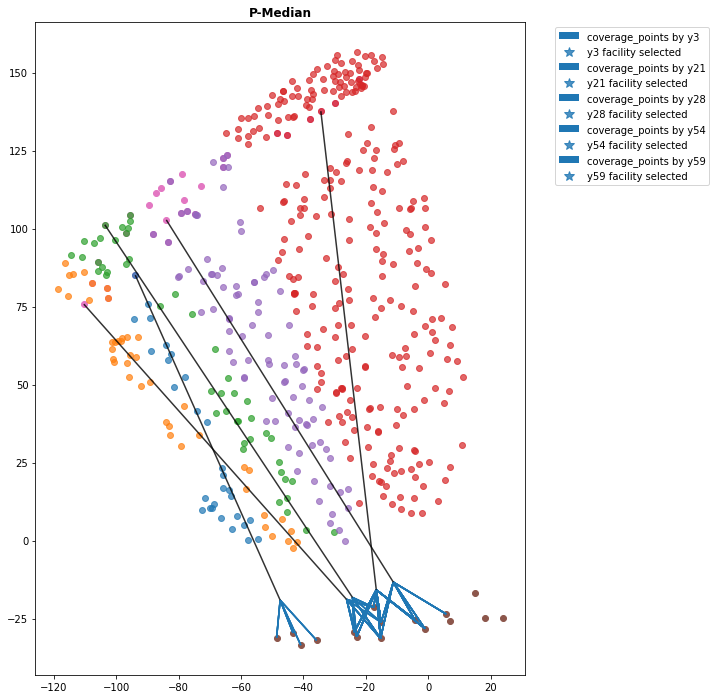

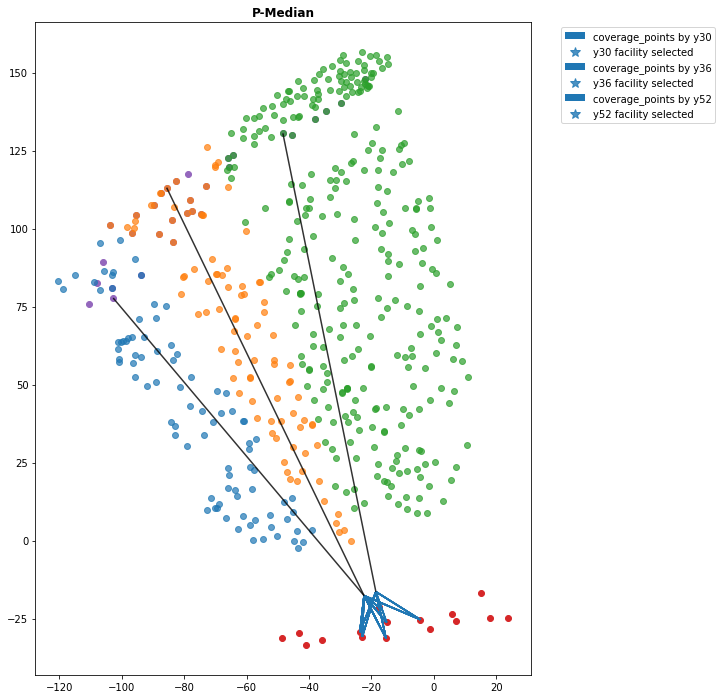

In [61]:
# Visualizations
client_range = cost_matrix.shape[0]
facility_range = cost_matrix.shape[1]
cli_assgn_vars = variable_matrix[:-1]
fac_vars = variable_matrix[-1:]

reload(plotting)

for x_sol in range(0,X.shape[0],4):
    plotting.plot_pymoo_results(X[x_sol], facility_points_gdf, demand_points_gdf, anchor_trees_gdf_filtered_diameter, target_trees_gdf_filtered_diameter, line_gdf)

In [22]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(8,5)})

# for x_sol in range(0,X.shape[0],4):
#     plotting.plot_pymoo_results(X[x_sol], facility_points_gdf, demand_points_gdf, anchor_trees_gdf_filtered_diameter, target_trees_gdf_filtered_diameter, line_gdf)

def plot_explain(i):
    plotting.plot_pymoo_results(X[int(i)], facility_points_gdf, demand_points_gdf, anchor_trees_gdf_filtered_diameter, target_trees_gdf_filtered_diameter, line_gdf)

%matplotlib inline

import numpy as np

interact(plot_explain, i = widgets.FloatSlider(value=1, min=1, max=X.shape[0], step=1))

interactive(children=(FloatSlider(value=1.0, description='i', max=51.0, min=1.0, step=1.0), Output()), _dom_cl…

<function __main__.plot_explain(i)>

In [33]:
range(0,X.shape[0],4)

range(0, 77, 4)